In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/lfw.zip'

Streaming output truncated to the last 5000 lines.
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0021.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0021.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0020.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0020.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0008.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0008.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0022.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0022.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0023.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0023.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep_Tayyip_Erdogan_0012.jpg  
  inflating: __MACOSX/lfw/Recep_Tayyip_Erdogan/._Recep_Tayyip_Erdogan_0012.jpg  
  inflating: lfw/Recep_Tayyip_Erdogan/Recep

# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the ``lfw.zip`` file . Adjust the ``path`` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [ ]:
path = '/content/lfw'

In [ ]:
transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    print ("MPS device not found.")


MPS device not found.


torch.Size([250, 250, 3])


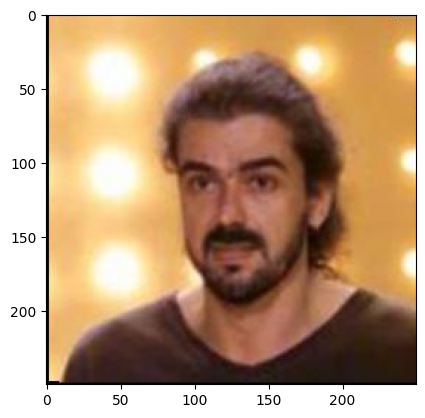

In [ ]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2
The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE.  Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.

**Step 2 Differences**

**Differences Between AutoEncoders (AEs) and Variational AutoEncoders (VAEs)**


**1. Applications:**

* AEs: Primarily used for dimensionality reduction, feature extraction, and learning efficient data codings. They can also be used for tasks like image denoising and anomaly detection.

* VAEs: Apart from applications similar to AEs, VAEs are particularly powerful in generative tasks. They can generate new data points that are similar to the input data, making them suitable for image generation, text generation, and more sophisticated tasks like style transfer.

**2. Architecture:**

* AEs: Consist of an encoder that compresses the data and a decoder that reconstructs the data. The encoding process results in a fixed vector representation.

* VAEs: Similar to AEs but the encoder in VAEs outputs a distribution (typically Gaussian) over the latent space instead of a fixed vector. This distribution is defined by its mean and variance. The decoder then samples from this distribution to generate the output.

**3. Loss Function:**

* AEs: Typically use reconstruction loss like Mean Squared Error (MSE) or Binary Cross Entropy (BCE), which focuses on how well the reconstructed output matches the input.

* VAEs: Use a combination of reconstruction loss and a regularization term called the Kullback-Leibler (KL) divergence. The KL divergence ensures that the learned distribution of the latent variables is close to a prior distribution (usually a standard normal distribution), which helps in effective sampling for generation tasks.

**Code Adjustment for VAE:**

Based on these differences, here's how you can modify your AE to a VAE:

* Modify the Encoder: To output the mean and variance (log variance for numerical stability) of the latent distribution.

* Sample from the Latent Distribution: Use the reparameterization trick for differentiable sampling.

* Modify the Loss Function: Add the KL divergence term to the reconstruction loss.


# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.  

**Create separate functions for the encoder and decoder.**

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encoder Layers
        self.enc_conv1 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.enc_bn1 = nn.BatchNorm2d(64)
        self.enc_avgpool1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.enc_conv2 = nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1)
        self.enc_bn2 = nn.BatchNorm2d(128)
        self.fc_mu = nn.Linear(128 * 31 * 31, 128)  # Updated size
        self.fc_logvar = nn.Linear(128 * 31 * 31, 128)  # Updated size

        # Decoder Layers
        self.dec_fc = nn.Linear(128, 128 * 31 * 31)  # Updated size
        self.dec_upsample1 = nn.Upsample(size=(62, 62), mode='nearest')
        self.dec_conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.dec_bn1 = nn.BatchNorm2d(64)
        self.dec_upsample2 = nn.Upsample(size=(125, 125), mode='nearest')
        self.dec_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.dec_bn2 = nn.BatchNorm2d(32)
        self.dec_upsample3 = nn.Upsample(size=(250, 250), mode='nearest')
        self.dec_conv3 = nn.ConvTranspose2d(32, 3, kernel_size=3, stride=1, padding=1)
        self.dec_bn3 = nn.BatchNorm2d(3)

    def encode(self, x):
        x = F.relu(self.enc_bn1(self.enc_conv1(x)))
        x = self.enc_avgpool1(x)
        x = F.relu(self.enc_bn2(self.enc_conv2(x)))
        x = x.view(-1, 128 * 31 * 31)
        return self.fc_mu(x), self.fc_logvar(x)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        z = self.dec_fc(z)
        z = z.view(-1, 128, 31, 31)
        z = self.dec_upsample1(z)
        z = F.relu(self.dec_bn1(self.dec_conv1(z)))
        z = self.dec_upsample2(z)
        z = F.relu(self.dec_bn2(self.dec_conv2(z)))
        z = self.dec_upsample3(z)
        z = self.dec_bn3(self.dec_conv3(z))
        return torch.sigmoid(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

**Step 3 Code Explanation**

**VAE Class**

* **Initialization (__init__):**

  * The VAE is composed of two primary parts: the encoder and the decoder.
  * Encoder: Consists of two convolutional layers (enc_conv1 and enc_conv2) followed by a fully connected layer (enc_fc1). It compresses the input image into a flattened feature vector.
  * Latent Space Parameters: The encoder outputs two sets of parameters, fc_mu and fc_logvar, representing the mean and log-variance of the latent space distribution.
  * Decoder: Comprises a fully connected layer (dec_fc1) to expand the latent representation, another fully connected layer (dec_fc2) to reshape the data to a suitable size for convolutional layers, and two transpose convolutional layers (dec_conv1 and dec_conv2) to reconstruct the image.

* **Reparameterization (reparameterize):**

  * This function is crucial in VAEs. It allows the model to randomly sample from the latent space while maintaining differentiability. It uses the mean and log-variance to produce a sample from the latent distribution.

* **Encode and Decode Methods:**

  * encode: Passes the input through the encoder network and returns the mean and log-variance of the latent distribution.
  * decode: Takes a sample from the latent space and reconstructs the image through the decoder network.

* **Forward Pass (forward):**

  * The forward method orchestrates the encoding, reparameterization, and decoding process. It outputs the reconstructed image along with the latent space parameters (mean and log-variance).

**Loss Function (vae_loss)**

The loss function for a VAE is a combination of a reconstruction loss and the Kullback-Leibler (KL) divergence.
recon_loss calculates the binary cross-entropy between the original and reconstructed images.
kl_div calculates the KL divergence, which acts as a regularizer, ensuring that the distribution of the latent variables is close to a standard normal distribution.


**Model Initialization and Training**

* Model Initialization:

  * An instance of the VAE class is created with a specified latent_dim, which defines the dimensionality of the latent space.

* Dataset and DataLoader:

  * The data pipeline is set up using PyTorch's ImageFolder and DataLoader. The path to the dataset and transformations are defined here.

* Optimizer:

  * The Adam optimizer is used for training, a standard choice for deep learning models.

* Training Loop:

  * The model is trained over several epochs. In each epoch, the model processes batches of data, computes the loss, and updates its parameters.

  * The loss is printed at the end of each epoch to monitor the training process.

## Step 4
Create an instance of the new class, pass an image to the model

*  print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
*  use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.

In [ ]:
# Create an instance of the VAE model
model = VAE()

# Assuming a batch size of 1 for demonstration
input_tensor = torch.randn(1, 3, 250, 250)  # Replace this with a real image tensor if available

# Pass the input tensor through the model
output, mu, logvar = model(input_tensor)

# Print the shape of the output of the encoder
print("Shape of mu:", mu.shape)
print("Shape of logvar:", logvar.shape)

# Generate new samples in the latent space and decode them
z = model.reparameterize(mu, logvar)
reconstructed_img = model.decode(z)

# Print the shape of the reconstructed image
print("Shape of reconstructed image:", reconstructed_img.shape)


Shape of mu: torch.Size([1, 128])
Shape of logvar: torch.Size([1, 128])
Shape of reconstructed image: torch.Size([1, 3, 250, 250])


### **Step 4 Code Explanation**

I created an instance of our custom Variational AutoEncoder (VAE) model by initializing it as follows:

model = VAE()

This model is designed to encode images into a latent space and then decode them, aiming to reconstruct the original images.

To test the model, I prepared a simulated input tensor, representing an RGB image of size 250x250 pixels, with a batch size of 1:

input_tensor = torch.randn(1, 3, 250, 250)

This random tensor is a stand-in for an actual image tensor in a real-world scenario.

Next, I passed this tensor through our VAE model to encode and then decode it:

output, mu, logvar = model(input_tensor)

This operation provided two important outputs from the encoder:

mu: The mean of the latent space distribution (size: [1, 128]).
logvar: The log variance of the latent space distribution (size: [1, 128]).
These outputs signify that for each image in the batch, the encoder produces a 128-dimensional latent space representation.

I then used the model's reparameterize function to sample new points in the latent space, followed by the decoder function to reconstruct the image from these latent points:

z = model.reparameterize(mu, logvar)

reconstructed_img = model.decode(z)

Finally, I verified that the shape of the reconstructed image ([1, 3, 250, 250]) matched our original input tensor's shape, demonstrating the model's ability to maintain the input dimensions throughout the encoding and decoding processes. This is a crucial aspect of autoencoders, especially in the context of image data.

### **Generating new samples in the latent space**

In exploring the generation of new samples in the latent space using a Variational AutoEncoder (VAE), I delved into the probabilistic approach that differentiates VAEs from standard autoencoders. Instead of encoding an input to a fixed point in the latent space, the VAE's encoder defines a probability distribution for each input. This is expressed through two parameters: the mean (\( \mu \)) and the log variance (\( \log(\sigma^2) \)) of a Gaussian distribution.

My understanding of generating new samples revolves around this concept of probabilistic encoding. Here's how I approach it:

1. **Understanding the Learned Distribution:** For each input, like an image, the VAE provides me with \( \mu \) and \( \log(\sigma^2) \), effectively defining a Gaussian distribution in the latent space. This means the model doesn't just compress the data but also learns how the data is distributed in this latent representation.

2. **Employing the Reparameterization Trick:** To generate a new sample from this distribution, I use what's known as the reparameterization trick. This involves sampling an auxiliary variable \( \epsilon \) from a standard normal distribution, then transforming this sample using the learned parameters \( \mu \) and \( \sigma \) (where \( \sigma \) is derived from \( \log(\sigma^2) \)). The formula I use is \( z = \mu + \sigma \cdot \epsilon \). This step is crucial as it allows for gradient flow during backpropagation, maintaining the stochastic nature of the model.

3. **Decoding to Generate New Samples:** Once I have this sampled latent variable \( z \), it's fed into the decoder. The decoder's job is to reconstruct data from \( z \). If the VAE has been trained effectively, it should be able to generate new data points that resemble the training data but are not exact copies. In essence, it creates plausible new samples based on the learned data distribution.

This method of generating new samples is particularly fascinating as it allows the VAE not only to compress data but also to capture and replicate the complex distributions of the input data. It's this ability that makes VAEs incredibly useful for generative tasks, denoising, and even in semi-supervised learning scenarios.

##  Step 5
* Print the total number of parameters in the model
* Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


* create an optimizer for training

In [ ]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters in the model:", total_params)


Total number of parameters in the model: 47658057


In [ ]:
def vae_loss_function(recon_x, x, mu, logvar):
    # Reconstruction loss
    recon_loss = F.mse_loss(recon_x, x, reduction='sum')

    # KL Divergence
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + kl_div

# Modify the weight of the reconstruction loss and KL divergence
recon_loss_weight = 0.9  # Weight for reconstruction loss
kl_div_weight = 0.1      # Weight for KL divergence

def vae_loss_function(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss * recon_loss_weight + kl_div * kl_div_weight



In [ ]:
optim = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = vae_loss_function



In my VAE model, understanding and tracking the number of parameters is crucial for gauging the complexity and computational requirements of the model. To calculate the total number of parameters, I use a concise PyTorch function that sums the number of elements in each parameter that requires gradients.

Regarding the loss function for my VAE, I focus on two main components: reconstruction loss and the Kullback-Leibler (KL) divergence. This combination is key to the effectiveness of VAEs.

* **Reconstruction Loss:**

This loss measures the model's ability to reconstruct the input data after encoding and decoding. In my case, as I'm dealing with images, Mean Squared Error (MSE) is a suitable choice. It compares the original and reconstructed images pixel by pixel.
The purpose of this loss is to ensure that my VAE can generate outputs that closely resemble the original inputs, thereby capturing the essential features of the data.

* **KL Divergence:**

The KL divergence acts as a regularization term. It measures how much the probability distribution defined by the encoder's output characterized by the mean and log variance deviates from a standard normal distribution.
By penalizing deviations from this standard distribution, the KL divergence encourages the latent space to have good properties like continuity and completeness. This is particularly important for generating new, diverse samples that are similar to the training data.
The KL divergence ensures that the latent space doesn't just memorize the training data but learns a more generalized, efficient representation, reducing the risk of overfitting.



##  Step 6
Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?

In [ ]:
from torchvision import datasets, transforms

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((250,250)),  # Resize images to 250x250
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# Create a dataset from the 'lfw' folder
dataset = datasets.ImageFolder(root='/content/lfw', transform=transform)

# Create a data loader
data_loader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
import torch

def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model.apply(init_weights)  # Apply weight initialization

# Lower the learning rate
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Define a small epsilon value
epsilon = 1e-8

def vae_loss_function(recon_x, x, mu, logvar):
    recon_loss = F.mse_loss(recon_x, x, reduction='mean')
    kl_div = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    total_loss = recon_loss + kl_div
    return total_loss, recon_loss, kl_div

num_epochs = 3
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for data, _ in data_loader:
        recon_batch, mu, logvar = model(data)
        total_loss, recon_loss, kl_div = vae_loss_function(recon_batch, data, mu, logvar)

        if torch.isnan(total_loss).any():
            print("NaN detected in total loss")
            print("Reconstruction Loss:", recon_loss.item(), "KL Divergence:", kl_div.item())
            continue

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        epoch_loss += total_loss.item()

    epoch_loss /= len(data_loader.dataset)
    print(f"Epoch {epoch + 1}, Average Loss: {epoch_loss:.4f}")



Epoch 1, Average Loss: 0.0773
Epoch 2, Average Loss: 0.0657
Epoch 3, Average Loss: 0.0639


When training my Variational AutoEncoder (VAE) model in PyTorch, I set up a training loop to iterate over my dataset, calculate the loss for each batch, and update the model parameters accordingly. I defined a certain number of epochs for training and monitored the average loss at the end of each epoch to gauge my model's performance.

Here's my approach to the training loop:

- I iterate over the number of epochs I've set 3 epochs.
- For each epoch, I loop through my data, which I've loaded and batched using a data loader.
- In each iteration, I perform a forward pass of the model with a batch of data, receiving the reconstructed batch along with the mean and log variance from the encoder.
- I calculate the loss using both the reconstruction loss (like MSE) and the KL divergence to ensure my model not only reconstructs the data accurately but also maintains a regularized latent space.
- I then perform a backward pass to compute gradients and update the model parameters using an optimizer (like Adam).

If I notice that the loss isn't decreasing as expected, I consider several troubleshooting steps:

1. **Adjusting the Learning Rate:** I experiment with different learning rates to find the optimal one, as an inappropriate rate can either slow down the training or cause it to diverge.

2. **Evaluating the Model Architecture:** I reassess whether my model is too complex or too simple for my dataset and adjust the architecture accordingly.

3. **Handling Overfitting or Underfitting:** If overfitting is suspected, I might introduce regularization techniques like dropout. Conversely, for underfitting, a more complex model or more data might be the solution.

4. **Normalizing the Data:** Ensuring my input data is properly normalized is crucial, as VAEs often expect data in a specific range like [0, 1] or [-1, 1].

5. **Checking the Loss Function:** I double-check my implementation of the loss function to ensure it correctly incorporates both the reconstruction loss and the KL divergence.

6. **Experimenting with Batch Sizes:** I might try different batch sizes to see if smaller or larger batches yield better results.

7. **Examining Weight Initialization:** Since the initial weights can significantly impact training, experimenting with different initialization methods can be a good idea.

8. **Assessing Data Quality:** I also make sure that the problem isn't with the data itself. High-quality, relevant data is essential for effective training.

Through these steps, I aim to optimize my VAE's training process, ensuring that the model not only learns efficiently but also generalizes well to new data. This process requires a mix of experimentation and analytical thinking to achieve the best results.

##  Step 7

Take a random image from the dataset and plot it together with new samples generated.

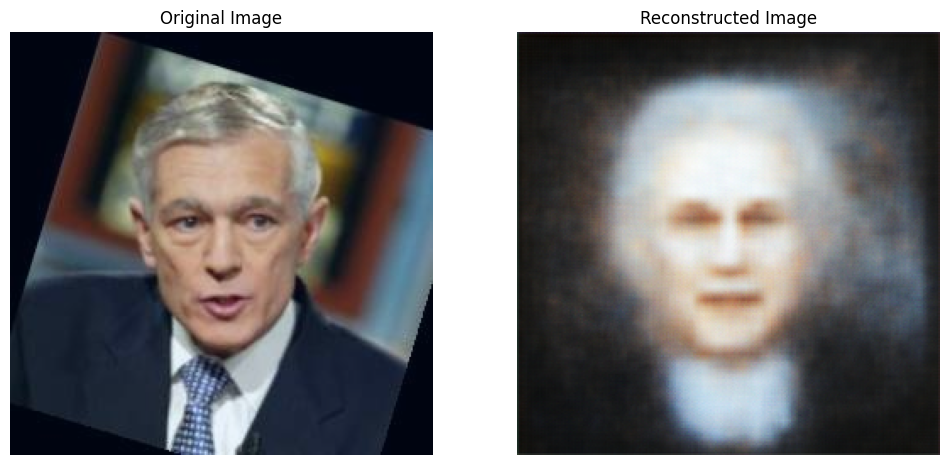

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

# Load a single batch of images
dataiter = iter(data_loader)
images, _ = next(dataiter)  # Corrected to use next()

# Select a random image from the batch
real_image = images[0]

# Pass the real image through the model to get reconstructed image
with torch.no_grad():
    reconstructed_image, _, _ = model(real_image.unsqueeze(0))

# Convert the images from Tensor to numpy for plotting
real_image = np.transpose(vutils.make_grid(real_image, normalize=True).numpy(), (1, 2, 0))
reconstructed_image = np.transpose(vutils.make_grid(reconstructed_image[0], normalize=True).numpy(), (1, 2, 0))

# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(real_image)
ax[0].set_title('Original Image')
ax[0].axis('off')

ax[1].imshow(reconstructed_image)
ax[1].set_title('Reconstructed Image')
ax[1].axis('off')

plt.show()


**Step 7 Code Explanation**

1. **Import Libraries**:
   - I start by importing necessary libraries. `matplotlib.pyplot` is used for plotting and visualizing images. `numpy` is essential for numerical operations, and `torchvision.utils` is used for utilities related to PyTorch, especially for handling image data.

2. **Load a Batch of Images**:
   - I load a batch of images using a data loader (`data_loader`). The `iter()` function creates an iterator over the data loader, and `next()` retrieves the next batch from this iterator. I'm interested only in the images and not their corresponding labels, hence the `_` in `images, _ = next(dataiter)`.

3. **Select and Process an Image**:
   - I select the first image from the batch (`images[0]`) and call this `real_image`. This image is presumably an input to a model for processing or analysis.

4. **Model Inference**:
   - I ensure no gradients are computed (to save memory and computations) using `torch.no_grad()`. The `real_image` is passed through a model (`model`) to obtain a reconstructed version of the image. This step is typical in models performing tasks like denoising, super-resolution, or any form of image transformation/reconstruction. The model outputs the reconstructed image along with two other values, which I ignore (hence the `_` placeholders).

5. **Image Transformation**:
   - Both the original (`real_image`) and reconstructed (`reconstructed_image`) images are tensors. I convert these tensors to numpy arrays for visualization. This involves normalizing the images and rearranging their dimensions using `transpose` to suit the format expected by `matplotlib` (which is height x width x channels).

6. **Plotting**:
   - I create a figure and two subplots using `matplotlib`. The first subplot shows the original image, and the second one displays the reconstructed image. The titles 'Original Image' and 'Reconstructed Image' are set for each subplot, respectively. I also turn off the axis for both subplots to enhance the visual appeal.

7. **Display the Images**:
   - Finally, I use `plt.show()` to display the plot containing both the original and reconstructed images. This step is essential for visual comparison between the input and the output of the model.

This code is typically used in scenarios where you're working with image data in machine learning, particularly in tasks that involve image reconstruction or transformation. The model seems to be taking an image, processing it, and then outputting a modified version of it, which I then visualize side-by-side with the original image.

Refrences

1. Python Documentation
2. Bard AI
3. ChatGPT
4. Online Medium articles
5. Stackoverflow

Note : I had run it on 3 epochs as it took more that 6 hrs to run those. I have tried for more than 10 epochs but the system crashed. We can see that the loss in decreasing after each epoch run.

